<a href="https://colab.research.google.com/github/Smart-Pigs/Depth-Images/blob/main/Weight_Estimation_MultiInput_SimpleCNN_Cropped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure you have this folder as shortcut in your drive - /content/gdrive/MyDrive/Morota-video-data/ 

In [1]:
#Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


### Data Loading

In [2]:
#@markdown Select resolution of input dataset and weeks of data

Instantiate_New_Dataset = True #@param {type:"boolean"}
Refresh_Old_Dataset = False #@param {type:"boolean"}

if Instantiate_New_Dataset == True:
  !rm -rf Week*/

Resolution = "256"  #@param ['720', '512', '256']

if Refresh_Old_Dataset == False:
  if Resolution == "720":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_720.zip .
    !unzip -qq CROPPED_WEEK1-10_720.zip -d .
    !rm -rf *WEEK*.zip

  if Resolution == "512":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_512.zip .
    !unzip -qq CROPPED_WEEK1-10_512.zip -d .
    !rm -rf *WEEK*.zip

  if Resolution == "256":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_256.zip .
    !unzip -qq CROPPED_WEEK1-10_256.zip -d .
    !rm -rf *WEEK*.zip

### Mapping Table Input

In [47]:
import pandas as pd

In [48]:
final_map = pd.read_csv("/content/gdrive/MyDrive/Morota-video-data/final_mapping.csv")

In [49]:
weeks = final_map

In [50]:
weeks

,image_path,Date,Pig,weight,Week
0,Week1/20210922/20210922_3330_b/_Depth_4683.jpg,20210922,3330,15.5,1
1,Week1/20210922/20210922_3330_b/_Depth_4778.jpg,20210922,3330,15.5,1
2,Week1/20210922/20210922_3330_b/_Depth_4579.jpg,20210922,3330,15.5,1
3,Week1/20210922/20210922_3330_b/_Depth_4578.jpg,20210922,3330,15.5,1
4,Week1/20210922/20210922_3330_b/_Depth_4584.jpg,20210922,3330,15.5,1
...,...,...,...,...,...
96220,Week10/20211119/20211119_3342/_Depth_3504.jpg,20211119,3342,56.6,10
96221,Week10/20211119/20211119_3342/_Depth_3318.jpg,20211119,3342,56.6,10
96222,Week10/20211119/20211119_3342/_Depth_3476.jpg,20211119,3342,56.6,10
96223,Week10/20211119/20211119_3342/_Depth_3169.jpg,20211119,3342,56.6,10


In [51]:
weeks_train = weeks[weeks["Pig"] != 3330]
#weeks_test = weeks[weeks['image_path'].str.contains('Week1/|Week2/')]

In [52]:
weeks_test = weeks[weeks["Pig"] == 3330]
#weeks_train = weeks[~weeks['image_path'].str.contains('Week1/|Week2/')]

In [53]:
image_paths_train = weeks_train['image_path'].values
labels_train = weeks_train['weight'].values
image_paths_test = weeks_test['image_path'].values
labels_test = weeks_test['weight'].values

In [10]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [54]:
input_train_dataset = tf.data.Dataset.from_tensor_slices((image_paths_train, labels_train))
input_test_dataset = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))

In [58]:
print("Number of elements in the train dataset:", tf.data.experimental.cardinality(input_train_dataset).numpy())
print("Number of elements in the test dataset:", tf.data.experimental.cardinality(input_test_dataset).numpy())

Number of elements in the train dataset: 69568
Number of elements in the test dataset: 26657


### Canny




In [55]:
IMG_SIZE = int(Resolution)
channels = 1

In [ ]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0

    edge_map = tf.numpy_function(canny_edge_detection, [img], tf.float32)
    edge_map.set_shape((IMG_SIZE, IMG_SIZE, 1))

    return (img, edge_map), label

def canny_edge_detection(image, low_threshold=100, high_threshold=200):
    image = image.squeeze() * 255
    image = image.astype(np.uint8)
    edge_map = cv2.Canny(image, low_threshold, high_threshold)
    edge_map = edge_map.astype(np.float32) / 255.0
    edge_map = np.expand_dims(edge_map, axis=-1)
    return edge_map

In [60]:
batch_size = 128

train_dataset = input_train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = input_test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

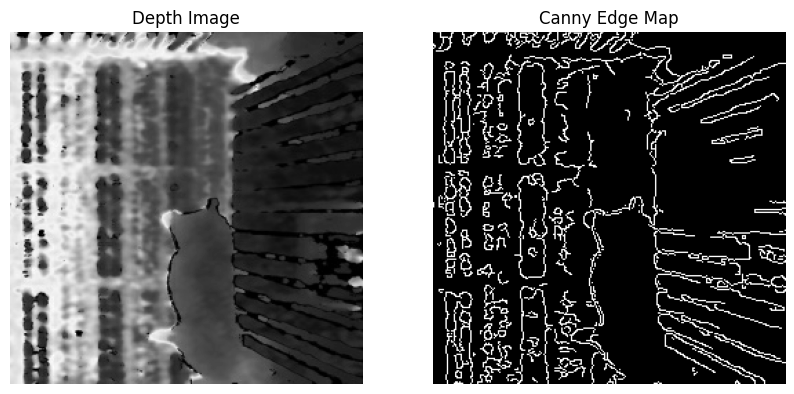

In [61]:
def visualize_sample(dataset):
    for (img_batch, edge_map_batch), label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()
        edge_map = edge_map_batch[0].numpy().squeeze()

        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(edge_map, cmap='gray')
        plt.title('Canny Edge Map')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [62]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

def create_multi_input_cnn():
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")
    edge_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="edge_input")

    depth_conv1 = Conv2D(16, (3, 3), activation="relu")(depth_input)
    depth_pool1 = MaxPooling2D((2, 2))(depth_conv1)
    depth_conv2 = Conv2D(32, (3, 3), activation="relu")(depth_pool1)
    depth_pool2 = MaxPooling2D((2, 2))(depth_conv2)

    edge_conv1 = Conv2D(16, (3, 3), activation="relu")(edge_input)
    edge_pool1 = MaxPooling2D((2, 2))(edge_conv1)
    edge_conv2 = Conv2D(32, (3, 3), activation="relu")(edge_pool1)
    edge_pool2 = MaxPooling2D((2, 2))(edge_conv2)

    concat = Concatenate()([depth_pool2, edge_pool2])
    flat = Flatten()(concat)
    dense1 = Dense(32, activation="relu")(flat)
    output = Dense(1)(dense1)

    model = Model(inputs=[depth_input, edge_input], outputs=output)

    return model

In [63]:
model = create_multi_input_cnn()

In [23]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [ ]:
model.summary()

In [25]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
544/544 [==============================] - 273s 490ms/step - loss: 52.3582 - mae: 4.6657 - mape: 16.1802 - val_loss: 30.6133 - val_mae: 4.3097 - val_mape: 13.0460
Epoch 2/50
544/544 [==============================] - 266s 488ms/step - loss: 11.7151 - mae: 2.4936 - mape: 8.8446 - val_loss: 25.4441 - val_mae: 3.8934 - val_mape: 11.8726
Epoch 3/50
544/544 [==============================] - 278s 510ms/step - loss: 7.9543 - mae: 2.0459 - mape: 7.2769 - val_loss: 29.0230 - val_mae: 4.0280 - val_mape: 11.4464
Epoch 4/50
544/544 [==============================] - 272s 500ms/step - loss: 5.9235 - mae: 1.7656 - mape: 6.2881 - val_loss: 22.7750 - val_mae: 3.6926 - val_mape: 11.3973
Epoch 5/50
544/544 [==============================] - 254s 466ms/step - loss: 4.4106 - mae: 1.5234 - mape: 5.4258 - val_loss: 28.3370 - val_mae: 3.9523 - val_mape: 11.2061
Epoch 6/50
544/544 [==============================] - 252s 462ms/step - loss: 3.4781 - mae: 1.3701 - mape: 4.8920 - val_loss: 28.7007 - v

KeyboardInterrupt: ignored

In [26]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

209/209 [==============================] - 57s 272ms/step - loss: 27.3205 - mae: 3.8584 - mape: 11.0795
Test loss: 27.32050132751465
Test mean absolute error: 3.8583743572235107
Test mean absolute percentage error: 11.079508781433105


### Sobel

In [82]:
IMG_SIZE = int(Resolution)
channels = 1

In [83]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0

    sobel_x, sobel_y = tf.numpy_function(sobel_edge_detection, [img], [tf.float32, tf.float32])
    sobel_x.set_shape((IMG_SIZE, IMG_SIZE, 1))
    sobel_y.set_shape((IMG_SIZE, IMG_SIZE, 1))

    return (img, sobel_x, sobel_y), label

def sobel_edge_detection(image):
    image = image.squeeze() * 255
    image = image.astype(np.uint8)
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    sobel_x = np.abs(sobel_x)
    sobel_y = np.abs(sobel_y)

    sobel_x = sobel_x.astype(np.float32) / 255.0
    sobel_y = sobel_y.astype(np.float32) / 255.0

    sobel_x = np.expand_dims(sobel_x, axis=-1)
    sobel_y = np.expand_dims(sobel_y, axis=-1)

    return sobel_x, sobel_y

In [84]:
batch_size = 128

train_dataset = input_train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = input_test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

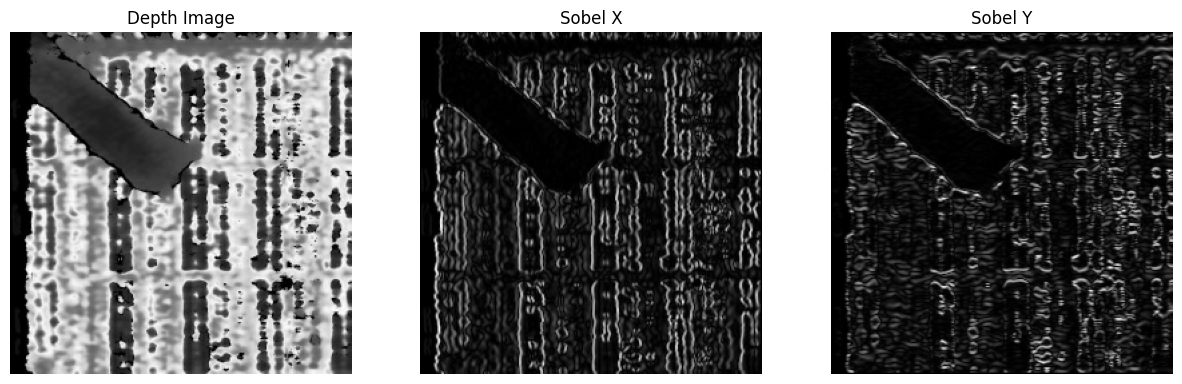

In [87]:
def visualize_sample(dataset):
    for (img_batch, sobel_x_batch, sobel_y_batch), label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()
        sobel_x = sobel_x_batch[0].numpy().squeeze()
        sobel_y = sobel_y_batch[0].numpy().squeeze()

        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(sobel_x, cmap='gray')
        plt.title('Sobel X')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(sobel_y, cmap='gray')
        plt.title('Sobel Y')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [71]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

def create_multi_input_cnn():
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")
    sobel_x_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="sobel_x_input")
    sobel_y_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="sobel_y_input")
    depth_conv1 = Conv2D(16, (3, 3), activation="relu")(depth_input)
    depth_pool1 = MaxPooling2D((2, 2))(depth_conv1)
    depth_conv2 = Conv2D(32, (3, 3), activation="relu")(depth_pool1)
    depth_pool2 = MaxPooling2D((2, 2))(depth_conv2)

    sobel_x_conv1 = Conv2D(16, (3, 3), activation="relu")(sobel_x_input)
    sobel_x_pool1 = MaxPooling2D((2, 2))(sobel_x_conv1)
    sobel_x_conv2 = Conv2D(32, (3, 3), activation="relu")(sobel_x_pool1)
    sobel_x_pool2 = MaxPooling2D((2, 2))(sobel_x_conv2)

    sobel_y_conv1 = Conv2D(16, (3, 3), activation="relu")(sobel_y_input)
    sobel_y_pool1 = MaxPooling2D((2, 2))(sobel_y_conv1)
    sobel_y_conv2 = Conv2D(32, (3, 3), activation="relu")(sobel_y_pool1)
    sobel_y_pool2 = MaxPooling2D((2, 2))(sobel_y_conv2)

    concat = Concatenate()([depth_pool2, sobel_x_pool2, sobel_y_pool2])
    flat = Flatten()(concat)
    dense1 = Dense(32, activation="relu")(flat)
    output = Dense(1)(dense1)

    model = Model(inputs=[depth_input, sobel_x_input, sobel_y_input], outputs=output)

    return model

In [72]:
model = create_multi_input_cnn()

In [73]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [74]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 depth_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 sobel_x_input (InputLayer)     [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 sobel_y_input (InputLayer)     [(None, 256, 256, 1  0           []                               
                                )]                                                          

In [75]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
544/544 [==============================] - 289s 523ms/step - loss: 36.4314 - mae: 4.0017 - mape: 13.7432 - val_loss: 28.3082 - val_mae: 4.0022 - val_mape: 12.0804
Epoch 2/50
544/544 [==============================] - 259s 476ms/step - loss: 8.1069 - mae: 1.9857 - mape: 6.9323 - val_loss: 38.0318 - val_mae: 4.5801 - val_mape: 12.5795
Epoch 3/50
544/544 [==============================] - 270s 497ms/step - loss: 4.7832 - mae: 1.5267 - mape: 5.3322 - val_loss: 26.1173 - val_mae: 3.8697 - val_mape: 11.4788
Epoch 4/50
 57/544 [==>...........................] - ETA: 2:33 - loss: 3.5512 - mae: 1.3237 - mape: 4.6472

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

209/209 [==============================] - 57s 272ms/step - loss: 27.3205 - mae: 3.8584 - mape: 11.0795
Test loss: 27.32050132751465
Test mean absolute error: 3.8583743572235107
Test mean absolute percentage error: 11.079508781433105


### Depth Gradients

In [88]:
IMG_SIZE = int(Resolution)
channels = 1

In [89]:
def depth_gradients(image):
    image = image.squeeze() * 255
    image = image.astype(np.float32)
    sobel_x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
    sobel_x = np.clip(sobel_x, 0, 255) / 255.0
    sobel_y = np.clip(sobel_y, 0, 255) / 255.0
    sobel_x = np.expand_dims(sobel_x, axis=-1)
    sobel_y = np.expand_dims(sobel_y, axis=-1)
    return sobel_x, sobel_y

def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0

    grad_x, grad_y = tf.numpy_function(depth_gradients, [img], [tf.float32, tf.float32])
    grad_x.set_shape((IMG_SIZE, IMG_SIZE, 1))
    grad_y.set_shape((IMG_SIZE, IMG_SIZE, 1))

    return (img, grad_x, grad_y), label

In [90]:
batch_size = 128

train_dataset = input_train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = input_test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

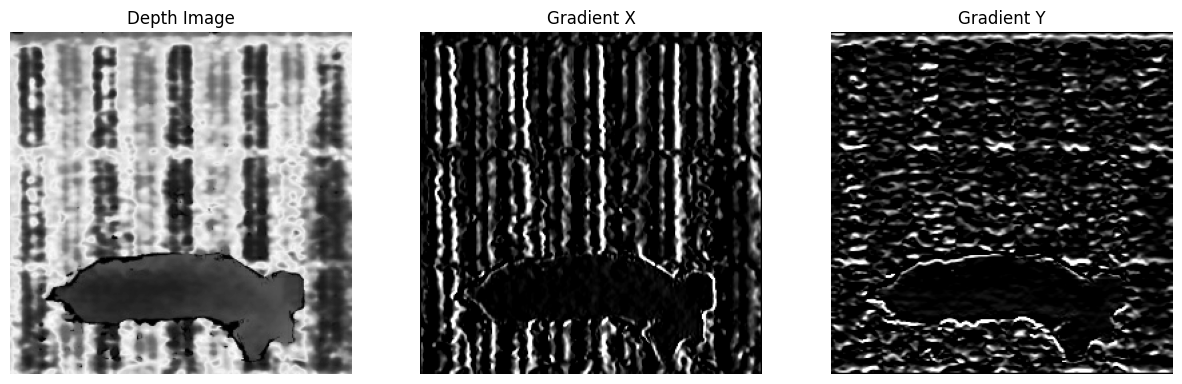

In [91]:
def visualize_sample(dataset):
    for (img_batch, grad_x_batch, grad_y_batch), label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()
        grad_x = grad_x_batch[0].numpy().squeeze()
        grad_y = grad_y_batch[0].numpy().squeeze()

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(grad_x, cmap='gray')
        plt.title('Gradient X')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(grad_y, cmap='gray')
        plt.title('Gradient Y')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [92]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

def create_multi_input_cnn():
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")
    sobel_x_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="sobel_x_input")
    sobel_y_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="sobel_y_input")
    depth_conv1 = Conv2D(16, (3, 3), activation="relu")(depth_input)
    depth_pool1 = MaxPooling2D((2, 2))(depth_conv1)
    depth_conv2 = Conv2D(32, (3, 3), activation="relu")(depth_pool1)
    depth_pool2 = MaxPooling2D((2, 2))(depth_conv2)

    sobel_x_conv1 = Conv2D(16, (3, 3), activation="relu")(sobel_x_input)
    sobel_x_pool1 = MaxPooling2D((2, 2))(sobel_x_conv1)
    sobel_x_conv2 = Conv2D(32, (3, 3), activation="relu")(sobel_x_pool1)
    sobel_x_pool2 = MaxPooling2D((2, 2))(sobel_x_conv2)

    sobel_y_conv1 = Conv2D(16, (3, 3), activation="relu")(sobel_y_input)
    sobel_y_pool1 = MaxPooling2D((2, 2))(sobel_y_conv1)
    sobel_y_conv2 = Conv2D(32, (3, 3), activation="relu")(sobel_y_pool1)
    sobel_y_pool2 = MaxPooling2D((2, 2))(sobel_y_conv2)

    concat = Concatenate()([depth_pool2, sobel_x_pool2, sobel_y_pool2])
    flat = Flatten()(concat)
    dense1 = Dense(32, activation="relu")(flat)
    output = Dense(1)(dense1)

    model = Model(inputs=[depth_input, sobel_x_input, sobel_y_input], outputs=output)

    return model

In [93]:
model = create_multi_input_cnn()

In [94]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [ ]:
model.summary()

In [96]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
544/544 [==============================] - 258s 466ms/step - loss: 40.5656 - mae: 4.2842 - mape: 14.8218 - val_loss: 29.6357 - val_mae: 4.1940 - val_mape: 12.5881
Epoch 2/50
544/544 [==============================] - 272s 501ms/step - loss: 9.6814 - mae: 2.2695 - mape: 8.0851 - val_loss: 23.8671 - val_mae: 3.7000 - val_mape: 10.9619
Epoch 3/50
544/544 [==============================] - 254s 467ms/step - loss: 6.1218 - mae: 1.8138 - mape: 6.4998 - val_loss: 28.1083 - val_mae: 3.9598 - val_mape: 11.1591
Epoch 4/50
354/544 [==================>...........] - ETA: 57s - loss: 4.2107 - mae: 1.5034 - mape: 5.3944

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

209/209 [==============================] - 57s 272ms/step - loss: 27.3205 - mae: 3.8584 - mape: 11.0795
Test loss: 27.32050132751465
Test mean absolute error: 3.8583743572235107
Test mean absolute percentage error: 11.079508781433105


### Local Binary Pattern


In [110]:
from skimage import feature

IMG_SIZE = int(Resolution)
channels = 1

In [111]:
# Preprocess image function
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0

    lbp = tf.numpy_function(compute_lbp, [img], tf.float32)
    lbp.set_shape((IMG_SIZE, IMG_SIZE, 1))

    return (img, lbp), label

def compute_lbp(image, num_points=8, radius=1):
    image = image.squeeze()
    lbp = feature.local_binary_pattern(image, num_points, radius, method='uniform')
    lbp = lbp.astype(np.float32) / (num_points + 1)
    lbp = np.expand_dims(lbp, axis=-1)
    return lbp

In [112]:
batch_size = 128

train_dataset = input_train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = input_test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

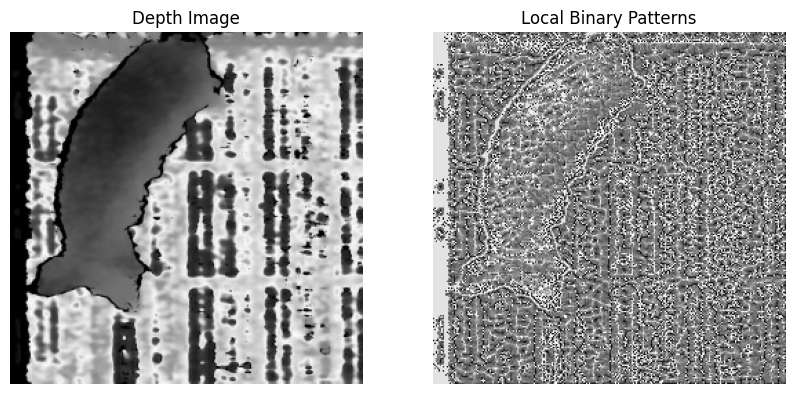

In [113]:
def visualize_sample(dataset):
    for (img_batch, lbp_batch), label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()
        lbp = lbp_batch[0].numpy().squeeze()

        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(lbp, cmap='gray')
        plt.title('Local Binary Patterns')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [114]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

def create_multi_input_cnn():
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")
    lbp_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="lbp_input")

    depth_conv1 = Conv2D(16, (3, 3), activation="relu")(depth_input)
    depth_pool1 = MaxPooling2D((2, 2))(depth_conv1)
    depth_conv2 = Conv2D(32, (3, 3), activation="relu")(depth_pool1)
    depth_pool2 = MaxPooling2D((2, 2))(depth_conv2)

    lbp_conv1 = Conv2D(16, (3, 3), activation="relu")(lbp_input)
    lbp_pool1 = MaxPooling2D((2, 2))(lbp_conv1)
    lbp_conv2 = Conv2D(32, (3, 3), activation="relu")(lbp_pool1)
    lbp_pool2 = MaxPooling2D((2, 2))(lbp_conv2)

    concat = Concatenate()([depth_pool2, lbp_pool2])
    flat = Flatten()(concat)
    dense1 = Dense(32, activation="relu")(flat)
    output = Dense(1)(dense1)

    model = Model(inputs=[depth_input, lbp_input], outputs=output)

    return model

In [115]:
model = create_multi_input_cnn()

In [116]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [117]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 depth_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lbp_input (InputLayer)         [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 254, 254, 16  160         ['depth_input[0][0]']            
                                )                                                           

In [118]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
212/544 [==========>...................] - ETA: 7:06 - loss: 77.5829 - mae: 6.4093 - mape: 21.9372

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

209/209 [==============================] - 57s 272ms/step - loss: 27.3205 - mae: 3.8584 - mape: 11.0795
Test loss: 27.32050132751465
Test mean absolute error: 3.8583743572235107
Test mean absolute percentage error: 11.079508781433105


### Filters

In [123]:
from scipy.ndimage import gaussian_filter

IMG_SIZE = int(Resolution)
channels = 1

In [124]:
# Preprocess image function
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0

    gaussian_filtered = tf.numpy_function(apply_gaussian_filter, [img], tf.float32)
    gaussian_filtered.set_shape((IMG_SIZE, IMG_SIZE, 1))

    return (img, gaussian_filtered), label

def apply_gaussian_filter(image, sigma=1):
    image = image.squeeze()
    filtered = gaussian_filter(image, sigma=sigma)
    filtered = np.expand_dims(filtered, axis=-1)
    return filtered

In [125]:
batch_size = 128

train_dataset = input_train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = input_test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

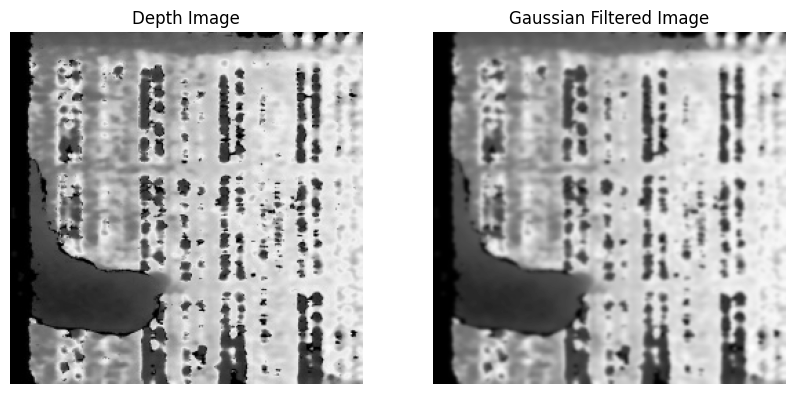

In [126]:
def visualize_sample(dataset):
    for (img_batch, filtered_batch), label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()
        filtered = filtered_batch[0].numpy().squeeze()

        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(filtered, cmap='gray')
        plt.title('Gaussian Filtered Image')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [127]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

def create_multi_input_cnn():
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")
    filtered_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="filtered_input")

    depth_conv1 = Conv2D(16, (3, 3), activation="relu")(depth_input)
    depth_pool1 = MaxPooling2D((2, 2))(depth_conv1)
    depth_conv2 = Conv2D(32, (3, 3), activation="relu")(depth_pool1)
    depth_pool2 = MaxPooling2D((2, 2))(depth_conv2)

    filtered_conv1 = Conv2D(16, (3, 3), activation="relu")(filtered_input)
    filtered_pool1 = MaxPooling2D((2, 2))(filtered_conv1)
    filtered_conv2 = Conv2D(32, (3, 3), activation="relu")(filtered_pool1)
    filtered_pool2 = MaxPooling2D((2, 2))(filtered_conv2)

    concat = Concatenate()([depth_pool2, filtered_pool2])
    flat = Flatten()(concat)
    dense1 = Dense(32, activation="relu")(flat)
    output = Dense(1)(dense1)

    model = Model(inputs=[depth_input, filtered_input], outputs=output)

    return model

In [128]:
model = create_multi_input_cnn()

In [129]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [130]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 depth_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 filtered_input (InputLayer)    [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 254, 254, 16  160         ['depth_input[0][0]']            
                                )                                                           

In [ ]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
287/544 [==============>...............] - ETA: 1:28 - loss: 40.7761 - mae: 4.4462 - mape: 15.2318

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

209/209 [==============================] - 57s 272ms/step - loss: 27.3205 - mae: 3.8584 - mape: 11.0795
Test loss: 27.32050132751465
Test mean absolute error: 3.8583743572235107
Test mean absolute percentage error: 11.079508781433105
